# Training a Neural Network to Approximate sin(x*y) Function

In this notebook, we will:
1. Create a fully connected neural network in PyTorch
2. Train it to approximate the function sin(x*y)
3. Evaluate the model's performance
4. Export the trained model to ONNX format

## 1. Imports and Setup

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


## 2. Data Generation

We'll generate synthetic data for training based on the function sin(x*y).

In [202]:
def generate_data(num_samples=1000, x_range=(-np.pi, np.pi), y_range=(-np.pi, np.pi)):
    """Generate synthetic data for training based on sin(x*y)"""
    # Generate random inputs
    x = np.random.uniform(x_range[0], x_range[1], (num_samples, 1))
    y = np.random.uniform(y_range[0], y_range[1], (num_samples, 1))
    
    # Compute targets: sin(x*y)
    targets = np.sin(x + y)
    
    # Create input features by stacking x and y
    inputs = np.hstack((x, y))
    
    # Convert to PyTorch tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    
    return inputs_tensor, targets_tensor

In [203]:
BATCH_SIZE = 64

# Create datasets
train_inputs, train_targets = generate_data(num_samples=5000)
val_inputs, val_targets = generate_data(num_samples=1000)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(train_inputs, train_targets)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_inputs, val_targets)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 5000
Validation samples: 1000


## 3. Model Definition

We'll define a fully connected neural network with configurable input size, hidden layers, and output size.

In [206]:
# Model architecture parameters (adjustable)
INPUT_SIZE = 2
HIDDEN_LAYERS = [128, 128]
OUTPUT_SIZE = 1

class SinModel(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_layers=HIDDEN_LAYERS, output_size=OUTPUT_SIZE):
        super(SinModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # Add output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Initialize model
model = SinModel().to(DEVICE)
print(model)

SinModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


## 4. Training Loop

In [207]:
# Training parameters
LEARNING_RATE = 0.001
EPOCHS = 500 #1000

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Lists to store metrics
train_losses = []
val_losses = []

# Training loop
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

print("Training complete!")

Epoch [100/500], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [200/500], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [300/500], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [400/500], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [500/500], Train Loss: 0.0001, Val Loss: 0.0002
Training complete!


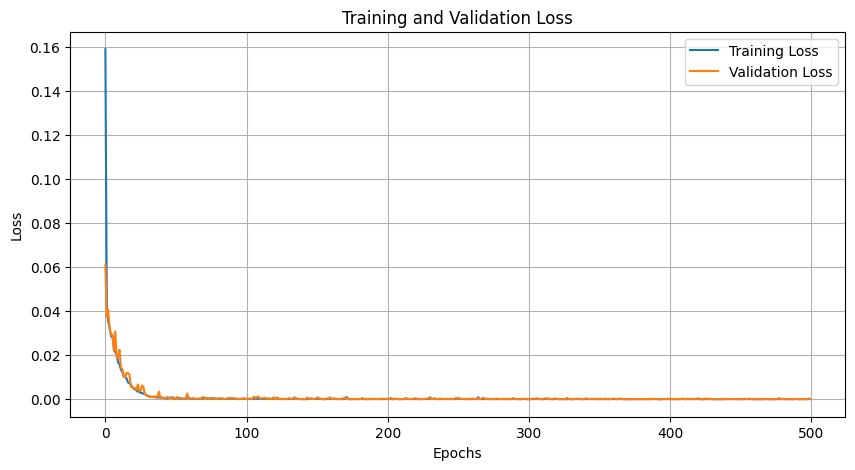

In [208]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. Model Evaluation

Test MSE: 0.0001


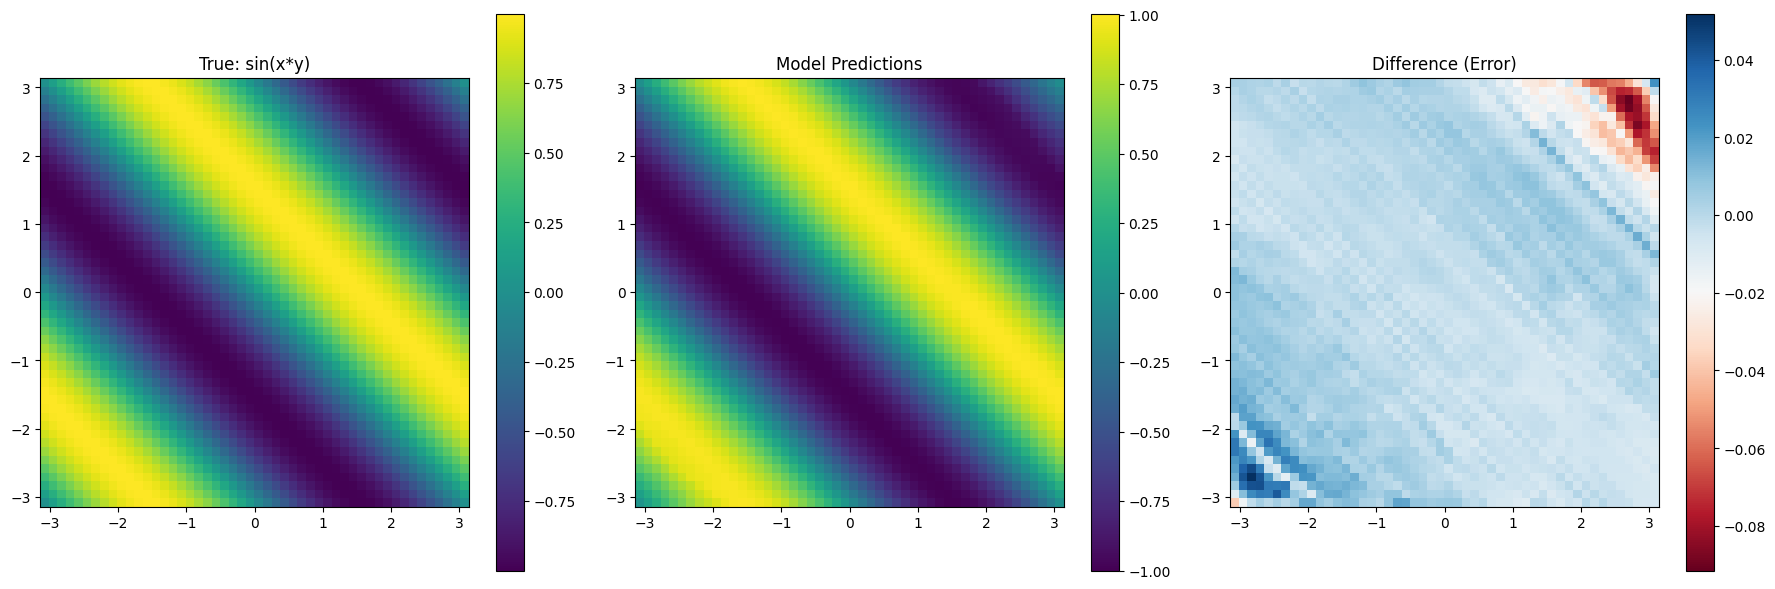

In [210]:
def evaluate_model(model, num_test_points=1000):
    """Evaluate the model on test data and visualize predictions"""
    # Generate test data
    test_inputs, test_targets = generate_data(num_samples=num_test_points)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(test_inputs.to(DEVICE)).cpu().numpy()
    
    # Calculate MSE
    mse = np.mean((predictions - test_targets.numpy()) ** 2)
    print(f'Test MSE: {mse:.4f}')
    
    # Create a grid for visualization
    grid_size = 50
    x = np.linspace(-np.pi, np.pi, grid_size)
    y = np.linspace(-np.pi, np.pi, grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Prepare inputs for the model
    grid_inputs = np.column_stack((X.flatten(), Y.flatten()))
    grid_inputs_tensor = torch.tensor(grid_inputs, dtype=torch.float32)
    
    # Make predictions on the grid
    with torch.no_grad():
        grid_predictions = model(grid_inputs_tensor.to(DEVICE)).cpu().numpy()
    
    # Reshape predictions for plotting
    Z_pred = grid_predictions.reshape(grid_size, grid_size)
    
    # Calculate true values
    Z_true = np.sin(X + Y)
    
    # Plot predictions vs true values
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # True function
    im0 = axes[0].imshow(Z_true, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='viridis')
    axes[0].set_title('True: sin(x*y)')
    plt.colorbar(im0, ax=axes[0])
    
    # Model predictions
    im1 = axes[1].imshow(Z_pred, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='viridis')
    axes[1].set_title('Model Predictions')
    plt.colorbar(im1, ax=axes[1])
    
    # Difference (error)
    im2 = axes[2].imshow(Z_true - Z_pred, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='RdBu')
    axes[2].set_title('Difference (Error)')
    plt.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

# Evaluate the trained model
evaluate_model(model)

In [211]:
#Export to torch file
# Save the entire model
torch.save(model, 'torch_model.pth')

In [252]:
import nobuco
from nobuco import ChannelOrder, ChannelOrderingStrategy
from nobuco.layers.weight import WeightLayer

dummy_image = torch.rand(size=(1,2))

keras_model = nobuco.pytorch_to_keras(
    model.eval(),
    args=[dummy_image], kwargs=None,
    inputs_channel_order=ChannelOrder.PYTORCH,
    outputs_channel_order=ChannelOrder.PYTORCH,
)
keras_model.save('keras_model')

[Nobuco] Tracing (DONE): : 7ops [00:00, 621.62ops/s]
[Nobuco] Converting (DONE): 100%|██████████| 5/5 [00:00<00:00, 287.13ops/s]

Legend:
    Green — conversion successful
    Yellow — conversion imprecise
    Red — conversion failed
    Red — no converter found
    Bold — conversion applied directly
    * — subgraph reused
    Tensor — this output is not dependent on any of subgraph's input tensors
    Tensor — this input is a parameter / constant
    Tensor — this tensor is useless

SinModel[__main__](float32_0<1,2>) -> float32_11<1,1>
 ├· Sequential[torch.nn.modules.container](float32_0<1,2>) -> float32_11<1,1>
 │   │  Linear[torch.nn.modules.linear](float32_0<1,2>) -> float32_3<1,128>
 │   │   └· linear[torch.nn.functional](float32_0<1,2>, float32_1<128,2>, float32_2<128>) -> float32_3<1,128>
 │   │  ReLU[torch.nn.modules.activation](float32_3<1,128>) -> float32_4<1,128>
 │   │   ├· relu[torch.nn.functional](float32_3<1,128>, inplace=False) -> float32_4<1,128>
 │   │   └   └· relu[torch](float32_3<1,128>) -> float32_4<1,128>
 │   │  Linear[torch.nn.modules.linear](float32_4<1,128>) -> float32_7<1,128>
 │   │ 

INFO:tensorflow:Assets written to: keras_model/assets


INFO:tensorflow:Assets written to: keras_model/assets


In [324]:
import tensorflow as tf

def representative_data_gen():
    for _ in range(1000):  # Use 100 samples for calibration
        input_value = np.random.uniform(-np.pi, np.pi, size=(2,)).astype(np.float32)  
        yield [input_value]  # Wrap in a list since the model expects batched input
    
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)  # Create a converter
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable optimizations (quantization)
converter.target_spec.supported_types = [tf.int8]  # Limit model to int8
converter.representative_dataset = representative_data_gen  # Use sample data for calibration
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Ensure int8 ops
converter.inference_input_type = tf.int8  # Input tensor type
converter.inference_type = tf.int8  # Internal computation type
converter.inference_output_type = tf.int8  # Output tensor type
# converter.inference_output_type = tf.float32  # Reduce output quantization error

tflite_model = converter.convert()
with open("./sin_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmpjrk8wxwm/assets


INFO:tensorflow:Assets written to: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmpjrk8wxwm/assets
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-13 02:10:55.414993: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-13 02:10:55.415004: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-13 02:10:55.415119: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmpjrk8wxwm
2025-03-13 02:10:55.415575: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-13 02:10:55.415580: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/fm/j5zs

In [254]:
import os

os.system("xxd -i ./sin_model.tflite > ./sin_model.cc")


0

In [325]:
interpreter = tf.lite.Interpreter(model_path="./sin_model.tflite")
interpreter.allocate_tensors()


# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for input_detail in input_details:
    print(input_detail)
for output_detail in output_details:
    print(output_detail)

{'name': 'serving_default_args_0:0', 'index': 0, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([1, 2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.024622052907943726, -1), 'quantization_parameters': {'scales': array([0.02462205], dtype=float32), 'zero_points': array([-1], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 9, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([1, 1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.007855841889977455, -1), 'quantization_parameters': {'scales': array([0.00785584], dtype=float32), 'zero_points': array([-1], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [342]:



#get quantization parameters from input details
input_scale = input_details[0]['quantization_parameters']['scales'][0]
input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]
print("input scale,zero: ", input_scale, input_zero_point)

input_float = np.random.uniform(-np.pi, np.pi, size=2)

# input_quantized = np.round(input_float / input_scale + input_zero_point).astype(np.int8)
input_quantized = np.clip(np.round(input_float / input_scale + input_zero_point), -128, 127).astype(np.int8)

input_quantized = input_quantized.reshape((1,2))

interpreter.set_tensor(input_details[0]['index'], input_quantized)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the quantization parameters from the output details
output_scale = output_details[0]['quantization_parameters']['scales'][0]
output_zero_point = output_details[0]['quantization_parameters']['zero_points'][0]
print("output scale,zero: ", output_scale, output_zero_point)


# Apply dequantization formula: real_value = (quantized_value - zero_point) * scale
output_data_float = (output_data.astype(np.float32) - output_zero_point) * output_scale

x,y = input_float
true_val = np.sin(x+y)
print(f"Evaluating sin({x:.3f}+{y:.3f})")
print("Real value:", true_val)

pre_quant = keras_model.predict(input_float.reshape((1,2)))
print("Prequant: ", pre_quant)


# print("Int8 output:", output_data)
print("Quantized output:", output_data_float)
print(f"Total Error: {true_val - output_data_float}")

print("Model error: ", true_val - pre_quant)

input_test = np.clip(np.round(input_float / input_scale + input_zero_point), -128, 127).astype(np.int8)
input_test = (input_test - input_zero_point) * input_scale
output_test = np.sin(input_test[0]+input_test[1])
print("Quantization error input:", true_val - output_test)

# dequantized = (output_test - output_zero_point) * output_scale





input scale,zero:  0.024622053 -1
output scale,zero:  0.007855842 -1
Evaluating sin(-0.503+0.651)
Real value: 0.14729458218054386
1/1 [==============================] - 0s 11ms/step
Prequant:  [[0.1475235]]
Quantized output: [[0.149261]]
Total Error: [[-0.00196642]]
Model error:  [[-0.00022891]]
Quantization error input: 9.904926256748547e-05


## 6. Export to ONNX

The ONNX format allows us to deploy our model in various environments and frameworks.

In [10]:
def export_to_onnx(model, filename='sin_model.onnx'):
    """Export the trained model to ONNX format"""
    # Create a dummy input tensor with the correct shape
    dummy_input = torch.randn(1, INPUT_SIZE, device=DEVICE)
    
    # Export the model
    torch.onnx.export(
        model,                       # model being run
        dummy_input,                 # model input (or a tuple for multiple inputs)
        filename,                    # where to save the model
        export_params=True,          # store the trained parameter weights inside the model file
        opset_version=12,            # the ONNX version to export the model to
        do_constant_folding=True,    # whether to execute constant folding for optimization
        input_names=['input'],       # the model's input names
        output_names=['output'],     # the model's output names
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"Model exported to {filename}")

# Export the model to ONNX
export_to_onnx(model)

Model exported to sin_model.onnx
